<a href="https://colab.research.google.com/github/royleekiat/hdbpricer/blob/main/hdbpricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDB Resale Price Prediction

Some inspiration (and code) taken from US Housing data prediction https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154

**Dataset for HDB Resale prices**
https://data.gov.sg/dataset/resale-flat-prices

In [1]:
%pip -q install tf-nightly

     |████████████████████████████████| 392.2MB 41kB/s 
     |████████████████████████████████| 471kB 56.7MB/s 
     |████████████████████████████████| 10.6MB 55.9MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from collections import defaultdict
import numpy as np
from numpy import unique
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard

INFO:tensorflow:Using local port 19433
INFO:tensorflow:Using local port 16397
INFO:tensorflow:Using local port 18954
INFO:tensorflow:Using local port 20179
INFO:tensorflow:Using local port 19699
INFO:tensorflow:Using local port 21581
INFO:tensorflow:Using local port 24366
INFO:tensorflow:Using local port 20304
INFO:tensorflow:Using local port 21442
INFO:tensorflow:Using local port 20496


In [3]:
tf.__version__

'2.4.0-dev20201012'

# Read data

In [4]:
#Dataset from https://data.gov.sg/dataset/resale-flat-prices
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8OfO82KXoRmO0E6c58MdwsOSc8ns5Geme87SiaiqTUrS_hI8u8mYE5KIOfQe4m2m3GGf9En22xuXx/pub?gid=382289391&single=true&output=csv"
data = pd.read_csv(file_url)



In [5]:
dataframe = data.copy()
dataframe.shape

(77895, 11)

In [6]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


# Visualize data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local

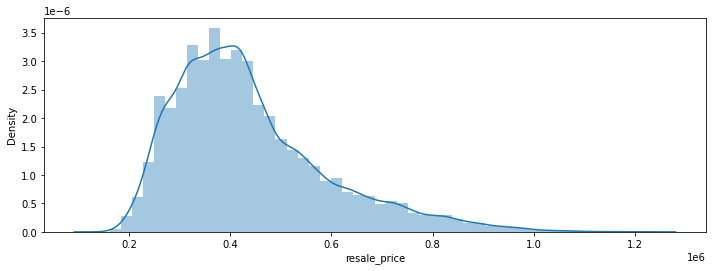

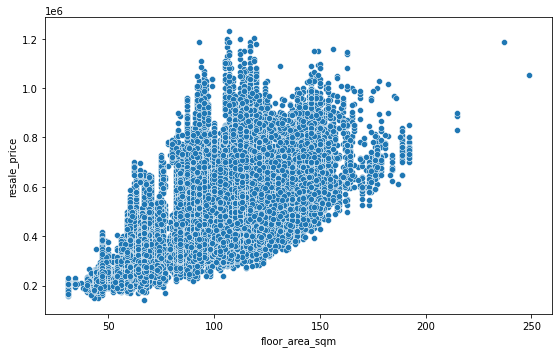

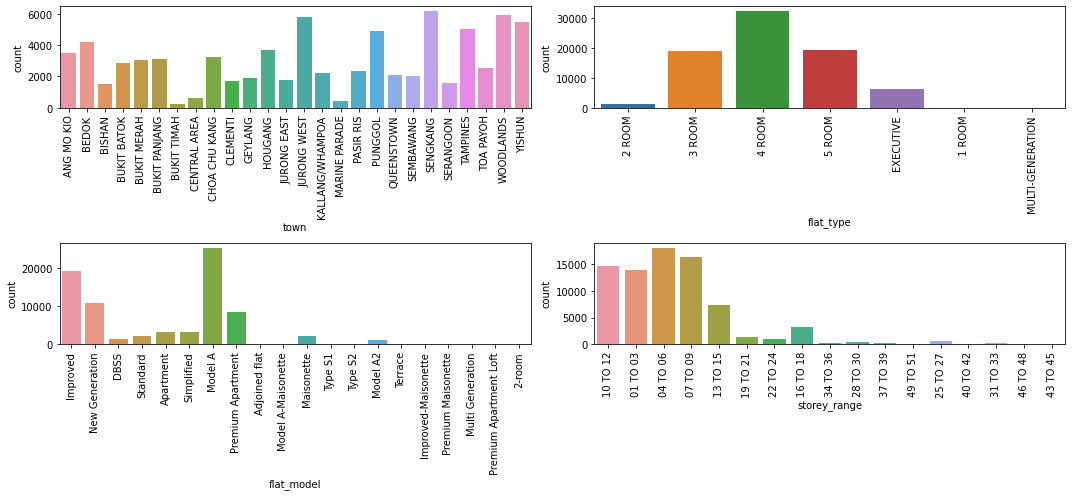

In [7]:
#visualizing house prices
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(dataframe['resale_price'])
plt.tight_layout()

#visualizing square metres
fig = plt.figure(figsize=(20,12))
fig.add_subplot(2,2,1)
sns.scatterplot(dataframe['floor_area_sqm'], dataframe['resale_price'])


#visualizing bedrooms,bathrooms,floors,grade
fig = plt.figure(figsize=(15,7))
fig.add_subplot(2,2,1)
sns.countplot(dataframe['town'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,2)
sns.countplot(dataframe['flat_type'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,3)
sns.countplot(dataframe['flat_model'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,4)
sns.countplot(dataframe['storey_range'])
plt.xticks(rotation=90)

plt.tight_layout()


# Preprocess data

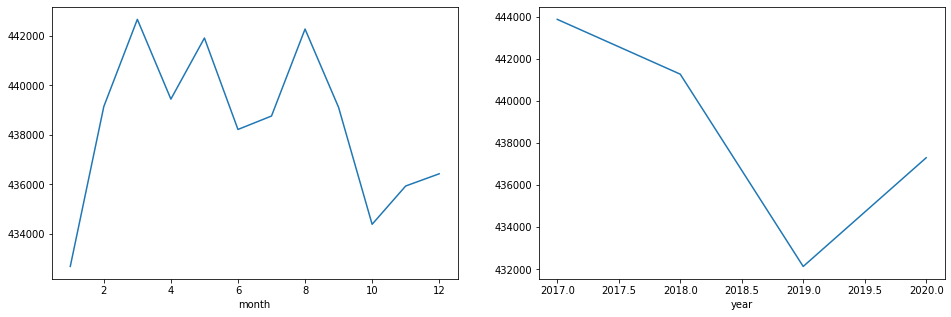

In [8]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])

#Get storey range as a continuous number
dataframe['storey_range'] = dataframe['storey_range'].apply(lambda storey_range:storey_range[:2])

#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
dataframe.groupby('month').mean()['resale_price'].plot()
fig.add_subplot(1,2,2)
dataframe.groupby('year').mean()['resale_price'].plot()


We can also use Google Geocode rest API to enrich the dataframe with longtitude and latitude data. For example,
import requests

response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA')

resp_json_payload = response.json()

print(resp_json_payload['results'][0]['geometry']['location'])

OR

USe Geopy and Geopanda as shown here https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [9]:
%pip install geopandas
%pip install geopy

     |████████████████████████████████| 972kB 4.6MB/s 
     |████████████████████████████████| 10.9MB 24.2MB/s 
     |████████████████████████████████| 14.8MB 181kB/s 


# Geocode locations

In [10]:
#Concat address

dataframe['address'] = dataframe['block'].map(str) + ', ' + dataframe['street_name'].map(str) + ', Singapore' 

In [11]:

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import folium
from folium.plugins import FastMarkerCluster
from geopy.extra.rate_limiter import RateLimiter

'''
#Geocode by address
locator = Nominatim(user_agent="myGeocoder")

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
dataframe['location'] = dataframe['address'].apply(geocode)
print("step 2")
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dataframe['point'] = dataframe['location'].apply(lambda loc: tuple(loc.point) if loc else None)
print("step 3")
# 4 - split point column into latitude, longitude and altitude columns
dataframe[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dataframe['point'].tolist(), index=df.index)
print("step 4")
'''
#Geocode by town (Singapore is so small that geocoding by addresses might not make much difference compared to geocoding to town)
town = [x for x in dataframe['town'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(town)):
    # remove things that does not seem usefull here
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(town[i])
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the locatio, latitude and longitude
df_ = pd.DataFrame({'town':town, 
                    'latitude': latitude,
                    'longitude':longitude})
# merge on Restaurant_Location with rest_df to get the column 
dataframe = dataframe.merge(df_, on='town', how='left')


The geographical coordinate of location are 1.3700803, 103.8495228.
The geographical coordinate of location are 1.3239765, 103.930216.
The geographical coordinate of location are 1.3509859, 103.84825507492937.
The geographical coordinate of location are 1.3490572, 103.7495906.
The geographical coordinate of location are 4.5592879, 101.0255816.
The geographical coordinate of location are 1.3791486, 103.76141301431002.
The geographical coordinate of location are 1.3546901, 103.7763724.
The geographical coordinate of location are 36.5070827, -79.7447575.
The geographical coordinate of location are 1.3847493, 103.7445341.
The geographical coordinate of location are 1.3151003, 103.7652311.
The geographical coordinate of location are 1.3181862, 103.8870563.
The geographical coordinate of location are 1.3708011, 103.89254433997465.
The geographical coordinate of location are 1.333108, 103.7422939.
The geographical coordinate of location are 1.3396365, 103.7073387.
The geographical coordinate 

In [12]:
dataframe.head(100)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year,address,latitude,longitude
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10,44.0,Improved,1979,61,232000.0,2017-01-01,2017,"406, ANG MO KIO AVE 10, Singapore",1.370080,103.849523
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01,67.0,New Generation,1978,60,250000.0,2017-01-01,2017,"108, ANG MO KIO AVE 4, Singapore",1.370080,103.849523
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,262000.0,2017-01-01,2017,"602, ANG MO KIO AVE 5, Singapore",1.370080,103.849523
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04,68.0,New Generation,1980,62,265000.0,2017-01-01,2017,"465, ANG MO KIO AVE 10, Singapore",1.370080,103.849523
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,265000.0,2017-01-01,2017,"601, ANG MO KIO AVE 5, Singapore",1.370080,103.849523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,BEDOK,4 ROOM,78,BEDOK NTH RD,04,91.0,New Generation,1978,60,382000.0,2017-01-01,2017,"78, BEDOK NTH RD, Singapore",1.323976,103.930216
96,1,BEDOK,4 ROOM,135,BEDOK RESERVOIR RD,07,84.0,Simplified,1987,69,384000.0,2017-01-01,2017,"135, BEDOK RESERVOIR RD, Singapore",1.323976,103.930216
97,1,BEDOK,4 ROOM,148,BEDOK RESERVOIR RD,13,84.0,Simplified,1987,69,385000.0,2017-01-01,2017,"148, BEDOK RESERVOIR RD, Singapore",1.323976,103.930216
98,1,BEDOK,4 ROOM,81,BEDOK NTH RD,01,91.0,New Generation,1978,60,390000.0,2017-01-01,2017,"81, BEDOK NTH RD, Singapore",1.323976,103.930216


In [13]:
# check if there are any Null values
dataframe.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
date                   0
year                   0
address                0
latitude               0
longitude              0
dtype: int64

# Encode categorical string values

In [14]:
### label encode the categorical values and convert them to numbers 
'''
le = LabelEncoder()

dataframe['town']= le.fit_transform(dataframe['town'].astype(str))

dataframe['flat_type'] = le.fit_transform(dataframe['flat_type'].astype(str))

dataframe['street_name'] = le.fit_transform(dataframe['street_name'].astype(str))

#dataframe['storey_range'] = le.fit_transform(dataframe['storey_range'].astype(str))

dataframe['flat_model'] = le.fit_transform(dataframe['flat_model'].astype(str))

dataframe['block'] = le.fit_transform(dataframe['block'].astype(str))

dataframe['address'] = le.fit_transform(dataframe['address'].astype(str))
'''

townDict = {'ANG MO KIO': 1,'BEDOK': 2,'BISHAN': 3,'BUKIT BATOK': 4,'BUKIT MERAH': 5,'BUKIT PANJANG': 6,'BUKIT TIMAH': 7,'CENTRAL AREA': 8,'CHOA CHU KANG': 9,'CLEMENTI': 10,'GEYLANG': 11,'HOUGANG': 12,'JURONG EAST': 13,'JURONG WEST': 14,'KALLANG/WHAMPOA': 15,'MARINE PARADE': 16,'PASIR RIS': 17,'PUNGGOL': 18,'QUEENSTOWN': 19,'SEMBAWANG': 20,'SENGKANG': 21,'SERANGOON': 22,'TAMPINES': 23,'TOA PAYOH': 24,'WOODLANDS': 25,'YISHUN': 26,}
flat_typeDict = {'1 ROOM': 1,'2 ROOM': 2,'3 ROOM': 3,'4 ROOM': 4,'5 ROOM': 5,'EXECUTIVE': 6,'MULTI-GENERATION': 7,}


dataframe['town'] = dataframe['town'].replace(townDict, regex=True)
dataframe['flat_type'] = dataframe['flat_type'].replace(flat_typeDict, regex=True)



# Understand correlations

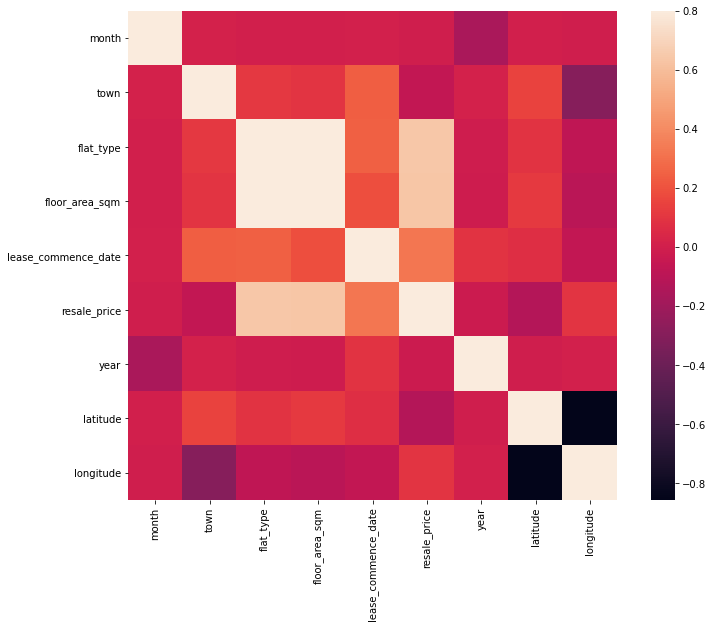

In [15]:
#correlation matrix
corrmat = dataframe.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

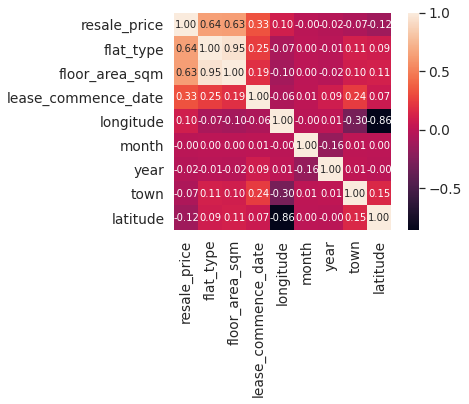

In [16]:
#resale_price correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(dataframe[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Drop columns with low correlations

In [17]:


# drop some unnecessary columns
dataframe = dataframe.drop('date',axis=1)

dataframe = dataframe.drop('block',axis=1)
#dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('address',axis=1)
dataframe = dataframe.drop('flat_model',axis=1)
#dataframe = dataframe.drop('town',axis=1)
dataframe = dataframe.drop('year',axis=1)
#dataframe = dataframe.drop('latitude',axis=1)
dataframe = dataframe.drop('remaining_lease',axis=1)








# Preview model input data

In [18]:
dataframe.head()

,town,flat_type,storey_range,floor_area_sqm,lease_commence_date,resale_price,latitude,longitude
0,1,2,10,44.0,1979,232000.0,1.37008,103.849523
1,1,3,01,67.0,1978,250000.0,1.37008,103.849523
2,1,3,01,67.0,1980,262000.0,1.37008,103.849523
3,1,3,04,68.0,1980,265000.0,1.37008,103.849523
4,1,3,01,67.0,1980,265000.0,1.37008,103.849523


# Data Split

In [19]:
#X = dataframe.drop('resale_price',axis =1).values
#y = dataframe['resale_price'].values

X = dataframe.drop('resale_price',axis =1)
y = dataframe['resale_price']



In [20]:
X=X.values
y=y.values

In [21]:
print(X[0])

[1 2 '10' 44.0 1979 1.3700803 103.8495228]


In [22]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [23]:
print(X_train[0])

[23 4 '01' 91.0 1984 1.3546528 103.9435712]


# Scaling

In [24]:
#standardization scaler - fit&transform on train, fit only on test

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))


#MinMax scaler - fit&transform on train, fit only on test
'''
s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))
'''

'\ns_scaler = MinMaxScaler()\nX_train = s_scaler.fit_transform(X_train.astype(np.float))\nX_test = s_scaler.transform(X_test.astype(np.float))\n'

# Model 1: Linear Regression

In [25]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)
#put results as a DataFrame
coeff_df = pd.DataFrame(regressor.coef_, dataframe.drop('resale_price',axis =1).columns, columns=['Coefficient']) 
coeff_df

438726.56080475025
[-23303.92408865  23763.86508526  43364.85980826  74563.50995063
  25084.6113144  -36339.58983993 -15139.19325723]


,Coefficient
town,-23303.924089
flat_type,23763.865085
storey_range,43364.859808
floor_area_sqm,74563.509951
lease_commence_date,25084.611314
latitude,-36339.589840
longitude,-15139.193257


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


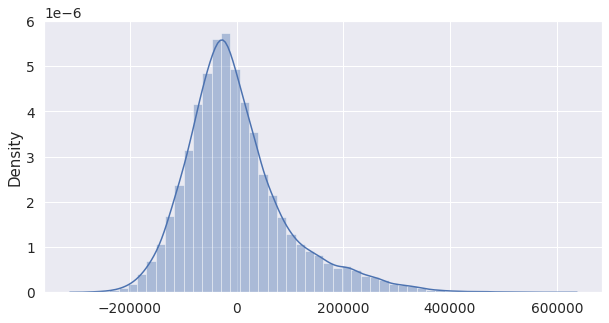

In [26]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)

In [27]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df1


,Actual,Predicted
0,318000.0,438507.992301
1,770000.0,520882.740728
2,851800.0,538331.202484
3,475000.0,512533.657286
4,320000.0,343942.388290
5,305000.0,360899.266588
6,460000.0,516238.557580
7,470000.0,413940.963681
8,468000.0,662196.628018
9,340000.0,517207.052462


In [28]:
print(y_test)

[318000. 770000. 851800. ... 350000. 450000. 360000.]


In [29]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

MAE: 72189.73698345898
MSE: 9413246271.327522
RMSE: 97021.88552758352
VarScore: 0.5966611367993274


# Model 2: Keras neural network

In [30]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam

In [31]:
# having 7 neuron is based on the number of available features
model = Sequential()
model.add(Dense(9,activation='relu'))
model.add(Dense(18,activation='relu'))
model.add(Dense(18,activation='relu'))
model.add(Dense(9,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [32]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)

model.summary()

Epoch 1/400
426/426 [==============================] - 1s 2ms/step - loss: 214865525057.3489 - val_loss: 197426675712.0000
Epoch 2/400
426/426 [==============================] - 1s 1ms/step - loss: 154842987277.7892 - val_loss: 29016162304.0000
Epoch 3/400
426/426 [==============================] - 1s 1ms/step - loss: 23636921106.5855 - val_loss: 15851044864.0000
Epoch 4/400
426/426 [==============================] - 1s 1ms/step - loss: 14870663774.7260 - val_loss: 12213007360.0000
Epoch 5/400
426/426 [==============================] - 1s 1ms/step - loss: 11976032025.7799 - val_loss: 10569812992.0000
Epoch 6/400
426/426 [==============================] - 1s 1ms/step - loss: 10621684407.4567 - val_loss: 9724096512.0000
Epoch 7/400
426/426 [==============================] - 1s 1ms/step - loss: 9668000669.6768 - val_loss: 9247040512.0000
Epoch 8/400
426/426 [==============================] - 1s 1ms/step - loss: 9343735935.1007 - val_loss: 8919955456.0000
Epoch 9/400
426/426 [=============

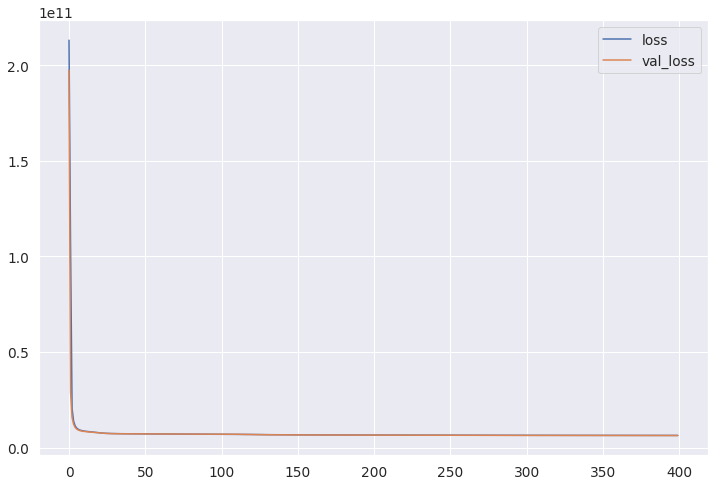

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

MAE: 56495.94624577432
MSE: 6340508352.301189
RMSE: 79627.30908614951
VarScore: 0.7283287366455662


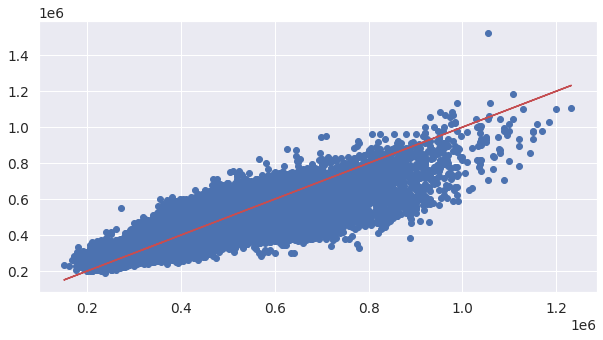

In [34]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [35]:
# visualizing residuals
'''
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)
'''

'\nfig = plt.figure(figsize=(10,5))\nresiduals = (y_test- y_pred)\nsns.distplot(residuals)\n'

In [36]:
print(y_pred)

[[385677.75]
 [509279.06]
 [493894.88]
 ...
 [310385.3 ]
 [570794.6 ]
 [344175.4 ]]


In [37]:
y_pred_2 = []
for pred in y_pred:
  y_pred_2.append(pred[0])

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2})
df1 = df.head(20)
df1

,Actual,Predicted
0,318000.0,385677.750000
1,770000.0,509279.062500
2,851800.0,493894.875000
3,475000.0,514704.062500
4,320000.0,302358.187500
5,305000.0,334527.906250
6,460000.0,453781.500000
7,470000.0,407535.875000
8,468000.0,709418.375000
9,340000.0,429401.937500


# Model 3: K nearest neighbours



We would like to try K nearest neighbours to try to improve our pricing accuracy. We use scikit learn, with reference to this example https://www.dataquest.io/blog/machine-learning-tutorial/

In [38]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')

In [39]:
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [40]:
print(X_test[0])

[-0.74191395 -0.14449066 -1.15402826  0.42595447  0.15439213 -0.11934425
  0.26425403]


In [41]:
predictions = knn.predict(X_test)


In [42]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = mse ** (1/2)
print(rmse)

46496.816061493475


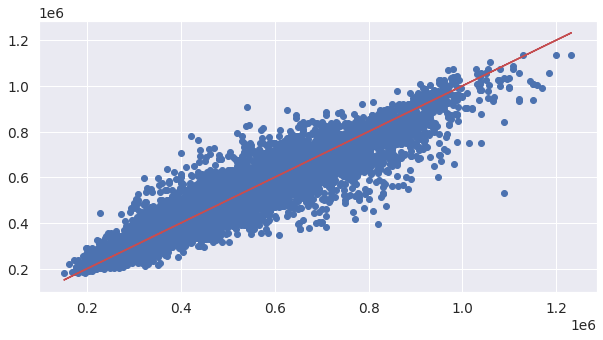

In [43]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,predictions)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [44]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df1 = df.head(20)
df1

,Actual,Predicted
0,318000.0,362600.0
1,770000.0,641600.0
2,851800.0,734600.0
3,475000.0,452577.6
4,320000.0,305600.0
5,305000.0,303800.0
6,460000.0,408300.0
7,470000.0,436000.0
8,468000.0,476000.0
9,340000.0,333600.0


# Conclusion

K nearest neighbours seems to have the best prediction with a relatively low RMSE. Neural networks come in second while Linear regression comes in last.